# Detecção de fraude - cartão de crédito - Kaggle

## Introdução

Este notebook utiliza base de dados do Kaggle:
- https://www.kaggle.com/dalpozz/creditcardfraud

A base de dados contém mais de 284 mil transações de cartão de crédito contendo hora, valor e
28 atributos normalizados obtidos através de transformação PCA de redução de dimensionalidade.
Assim, ao todo são 30 atributos. O alvo do problema é prever se a transação é fraudulenta ou
genuína.
Uma característica fundamental deste dataset e que é comum em sistemas de fraudes é a diferença
entre respostas positivas: 284315 versus respostas negativas fraudulentas: 492. As fraudes 
representam apenas 0,17% das transações.
Este problema pode ser visto como sendo um problema de detecção de anomalia, entretanto iremos
tratá-la como um problema de classificação em duas classes utilizando redes neurais com
várias técnicas de regularização.

## Importação

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from keras.models import Sequential, Input
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import advanced_activations
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Leitura dos dados

In [6]:
#dataframe = pd.read_csv('../../datasets/creditcard.csv', header=0)
dataframe = pd.read_csv('../../../mylocaldatasets/creditcard.csv', header=0)
dataframe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### converte rótulos para codificação one-hot e conta número de amostras em cada classe

In [7]:
label = np.asarray(dataframe['Class'])
categorical_labels = to_categorical(label, 2)
categorical_labels.sum(axis=0)

array([ 284315.,     492.])

### Aplica mod no Timestamp para ser uma indicação da hora diária e normaliza dados 

In [9]:
df_cp = dataframe.copy()
features = np.asarray(df_cp.values)[:,:-1]
timestamp = features[:,0]
timestamp = timestamp % (60* 60 * 24) # modulo número de segundos por dia
features -= features.min(axis=0)
features /= features.max(axis=0)
features[:1],features.shape

(array([[ 0.        ,  0.93519234,  0.76649042,  0.8813649 ,  0.31302266,
          0.76343873,  0.26766864,  0.26681518,  0.7864442 ,  0.47531173,
          0.51060048,  0.25248432,  0.68090763,  0.3715906 ,  0.63559053,
          0.4460837 ,  0.43439239,  0.73717255,  0.65506586,  0.59486323,
          0.58294223,  0.56118439,  0.52299212,  0.66379298,  0.39125268,
          0.58512179,  0.39455679,  0.41897614,  0.31269663,  0.00582379]]),
 (284807, 30))

### Visualiza com boxplot

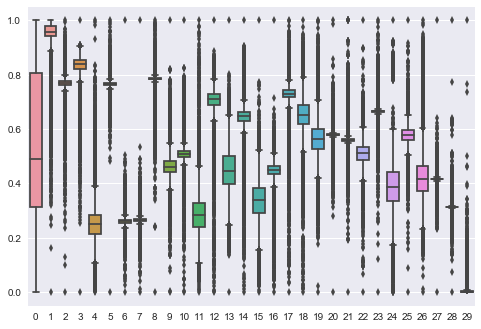

In [10]:
sns.boxplot(data=features[:,:])

## Separação dados em treinamento e teste (20%)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, categorical_labels, test_size=0.2, random_state=40)

In [14]:
FEATURE_NUM = 30
CLASSES = 2
MAX_RANGE = 100

In [15]:
print(X_train.shape)
print(y_train.sum(axis=0))

(227845, 30)
[ 227450.     395.]


## Definição da rede

In [17]:
model = Sequential()
model.add(BatchNormalization(input_shape=(FEATURE_NUM,)))
model.add(GaussianNoise(0.4))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASSES, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 30)                120       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               3100      
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
__________

## Treinamento

In [19]:
MAX_RANGE=10
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, y_train,
          epochs =MAX_RANGE,
          batch_size=1000,
          validation_data=(X_test, y_test))
          #callbacks=[checkpointer, tensorboard])

Train on 227845 samples, validate on 56962 samples
Epoch 1/10
227845/227845 [==============================] - 6s - loss: 0.0399 - acc: 0.9902 - val_loss: 0.0086 - val_acc: 0.9983

## Avaliação

In [20]:
y_hat = model.predict_classes(X_test)
y_class_test = (y_test.argmax(axis=1))

56832/56962 [============================>.] - ETA: 0s  

In [22]:
print(y_hat.shape,y_class_test.shape)
print(sklearn.metrics.confusion_matrix(y_class_test,y_hat))
print(sklearn.metrics.classification_report(y_class_test,y_hat))

(56962,) (56962,)
[[56851    14]
 [   14    83]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56865
          1       0.86      0.86      0.86        97

avg / total       1.00      1.00      1.00     56962



## Aprendizados